In [1]:
import sys
import importlib
sys.path.append('./qdarts')

from qdarts.experiment import Experiment
from qdarts.plotting import plot_polytopes

import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import utilities.config as c
import utilities.utils  as u
import utilities.model_utils  as mu

import torch

importlib.reload(c)
importlib.reload(u)
importlib.reload(mu)

<module 'utilities.model_utils' from 'd:\\!!!_PDF\\Fizyka i matma studia\\!!!_Leiden\\!! projekty 2024_25\\Evert van Niewenburg\\potencial projects\\Qdarts projects\\qdarts_code\\learning_parameters\\utilities\\model_utils.py'>

### Looking at the data

In [ ]:
if c.PATH_0 == './ALICE/':
    batch_number = 2
    img_number = '0035487789'
else:
    batch_number = 3
    img_number = '0060485230'

u.reconstruct_img_with_matrices(batch_number, img_number, True)[0]

### Data preprocessing

In [ ]:
# datapoints = mu.load_datapoints(param_names=['csd', 'C_DD', 'C_DG'])
datapoints = mu.load_datapoints(param_names=['csd', 'C_DD', 'C_DG'], all_batches=False, batches=np.arange(2,3))

print(f"The amount of datapoints loaded: {len(datapoints)}.")
print(f"The shape of CSD {datapoints[0][0].shape}, and its type {type(datapoints[0][0])}.")

#### Reconstructed image from saved np.ndarray

In [8]:
example = datapoints[19] # 67, 19

In [ ]:
example_csd = example[0]
u.reconstruct_img_from_tensor(example_csd)

#### The preprocessed input seen by the model

In [ ]:
%matplotlib inline

tensor = mu.preprocess_csd(example_csd)
mu.show_image_from_tensor(tensor)

#### Output preproccess

In [ ]:
c_dd, c_dg = example[1], example[2]
print(f"C_DD: \n {c_dd}\n")
print(f"C_DG: \n {c_dg}")

In [ ]:
# output -> a vector -> row by row first from C_DD, then C_DG -> K*(K+1)/2 + K^2 (elements)
#   
output = mu.preprocess_capacitance_matrices(c_dd, c_dg)
assert len(output) == c.K*(c.K+1)//2 + c.K**2

print(output) 

#### Filter dataset

In [ ]:
unfiltered_datapoints = datapoints.copy()
filtred_datapoints = mu.filter_dataset(datapoints)

print(f"Before filtration: {len(unfiltered_datapoints)}.\nAfter filtration: {len(filtred_datapoints)} ({100*len(filtred_datapoints)/len(unfiltered_datapoints):.2f}%).")
# datapoints = filtred_datapoints

#### Train model

### Unit tests

In [15]:
c_dd, c_dg = u.generate_capacitance_matrices()
output = mu.preprocess_capacitance_matrices(c_dd, c_dg)
c_dd_rec, c_dg_rec = mu.reconstruct_capacitance_matrices(output)

assert (c_dd == c_dd_rec).all() and (c_dg == c_dg_rec).all()

In [16]:
# output -> a vector -> row by row first from C_DD, then C_DG -> K*(K+1)/2 + K^2 (elements)outputmupepocess_cpacitance_matricesc_ddc_dg
# c_m = 0.5
# c_dd = np.array([[3.1, 0.5], [0.5, 2.9]])
# np.sum(c_dg, axis=1).T*np.eye(c.K)+c_m

c_dd, c_dg = u.generate_capacitance_matrices()
c_m =  c_dd[0,1]

c_dd_test = np.array([[c_dg[0,0]+c_dg[0,1]+c_m, c_m], [c_m, c_dg[1,0]+c_dg[1,1]+c_m]])

if c.K == 2:
    assert (c_dd == c_dd_test).all()
    assert c_dd[0,1] == c_dd[1,0]

### XAI

In [ ]:
test = mu.load_datapoints(param_names=['csd', 'C_DD', 'C_DG'], all_batches=False, batches=np.arange(41,42))
u.reconstruct_img_from_tensor(test[0][0])

In [ ]:
example_X, example_Y = mu.prepare_data(datasize_cut=1, 
                                       param_names=['csd', 'C_DD', 'C_DG'], 
                                       all_batches=False, batches=np.arange(41,42))

print(example_X.shape, example_Y.shape)
print(example_Y[-1])


In [ ]:
saliency_overlay, gradcam_overlay, prediction, reconstructed_matrices= mu.explain_output(
    input_tensor=example_X,
    model_name='resnet',
    model_path='./Results/resnet18/resnet18_model_20241028_104258/resnet18_model.pth')

print(prediction)
print(reconstructed_matrices)

In [ ]:
np.abs(np.array(example_Y) -  prediction)

In [ ]:
saliency_overlay

In [ ]:
gradcam_overlay

In [ ]:
%matplotlib inline
plot, ax = mu.generate_csd_from_prediction(prediction)
plot.show()

### Noise - test

In [5]:
c.NOISE = True
S = 1
device = np.array([[1,1]])
N = len(u.get_dots_indices(device))
K = S+N

config_tuple = (K,N,S)

C_DD, C_DG = u.generate_capacitance_matrices(device, config_tuple)
capacitance_config, tunneling_config, sensor_config = u.generate_experiment_config(C_DD, C_DG, config_tuple, device)

In [6]:
experiment = Experiment(capacitance_config=capacitance_config, 
                        tunneling_config=tunneling_config, 
                        sensor_config=sensor_config)

EXPERIMENT INITIALIZED
-----------------------

                Capacitance model deployed with the following parameters:
                Dot-dot capacitances: 
                [[17.5689  3.5788  0.5411]
 [ 3.5788 20.0288  0.3031]
 [ 0.5411  0.3031 14.6679]]
                Dot-gate capacitances: 
                [[4.9629e+00 1.4315e+00 1.7700e-02]
 [1.4315e+00 7.4305e+00 4.5000e-03]
 [1.7700e-02 4.5000e-03 6.4593e+00]]
                Size of Coulomb peaks V[n] is constant
                

            Sensor model deployed with the following parameters:   
            Sensor dot indices: [-1]
            Sensor detunings: [-20.] meV
            Coulomb peak width: 0.68 meV
            Slow noise amplitude: 0.0 ueV
            Fast noise amplitude: 0.0 ueV
            

            Tunneling model deployed with the following parameters:
            Tunneling matrix:
            [[0.e+00 1.e-04 0.e+00]
 [1.e-04 0.e+00 0.e+00]
 [0.e+00 0.e+00 0.e+00]]
            Temperature: 0.1 K
    

In [2]:
# dvmax = -0.01
# dvmin = -0.02
# v0, v1 = np.random.uniform(dvmin, dvmax, 2)

xks, yks, csd_dataks, polytopesks, sensor_signalexp, _ = experiment.generate_CSD(
                                                plane_axes = u.get_cut(config_tuple), # vectors spanning the cut in voltage space
                                                
                                                target_state = [1,0,5],  # target state for transition
                                                target_transition = [-1,1,0], #target transition from target state, here transition to [2,3,2,3,5,5]

                                                x_voltages=np.linspace(0, 0.05, 500), #voltage range for x-axis
                                                y_voltages=np.linspace(0, 0.05, 500), #voltage range for y-axis
                                                compute_polytopes = True,
                                                # compensate_sensors=True, #compensate the sensors
                                                 #compute the corners of constant occupation
                                                use_sensor_signal=True) #use the sensor signals   



NameError: name 'experiment' is not defined

In [ ]:
%matplotlib inline
fig, ax = u.plot_CSD(xks, yks, sensor_signalexp[:,:,0], polytopesks)  

In [ ]:
%matplotlib inline
plt.figure(figsize=(c.RESOLUTION/c.DPI, c.RESOLUTION/c.DPI), dpi=c.DPI)
plt.pcolormesh(np.gradient(sensor_signalexp[:,:,0],axis=0))
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [3]:
c.NOISE = True

x_vol = np.linspace(0, 0.05, 500)
y_vol = np.linspace(0, 0.05, 500)
ks = 0
device = np.array([[1,1]])

S=1
N=len(u.get_dots_indices(device))
K=N+S
config_tuple = (K,N,S)

C_DD, C_DG, ks, cut, x, y, csd, poly, sensor, device = u.generate_dataset(x_vol, y_vol, ks, device, config_tuple)

K: 3, N: 2, S: 1
c.NOISE: True, p_dd: 0.5, p_dg: 0.2
K: 3, N: 2, S: 1
c.NOISE: True, p_dd: 0.5, p_dg: 0.2
True
EXPERIMENT INITIALIZED
-----------------------

                Capacitance model deployed with the following parameters:
                Dot-dot capacitances: 
                [[13.5607  2.625   0.2526]
 [ 2.625  14.8756  0.5206]
 [ 0.2526  0.5206 16.9051]]
                Dot-gate capacitances: 
                [[4.5464e+00 1.0500e+00 3.6000e-03]
 [1.0500e+00 5.2390e+00 1.8600e-02]
 [3.6000e-03 1.8600e-02 8.4002e+00]]
                Size of Coulomb peaks V[n] is constant
                

            Sensor model deployed with the following parameters:   
            Sensor dot indices: [-1]
            Sensor detunings: [-20.] meV
            Coulomb peak width: 0.68 meV
            Slow noise amplitude: 0.0 ueV
            Fast noise amplitude: 0.0 ueV
            

            Tunneling model deployed with the following parameters:
            Tunneling matrix:
         

In [4]:
sensor

array([[2.82255411e-09, 2.86690533e-09, 2.91175319e-09, ...,
        1.37565985e-09, 1.38654172e-09, 1.39750816e-09],
       [2.83661194e-09, 2.88135671e-09, 2.92661842e-09, ...,
        1.39383843e-09, 1.40486160e-09, 1.41597043e-09],
       [2.85057301e-09, 2.89569905e-09, 2.94136210e-09, ...,
        1.41225302e-09, 1.42341928e-09, 1.43467230e-09],
       ...,
       [5.51796710e-09, 5.56087161e-09, 5.60410030e-09, ...,
        2.40106120e-09, 2.26497095e-09, 2.22383967e-09],
       [5.58875543e-09, 5.63220359e-09, 5.67597986e-09, ...,
        2.18242513e-09, 2.19082681e-09, 2.20795195e-09],
       [5.66043221e-09, 5.70443055e-09, 5.74876128e-09, ...,
        2.18389285e-09, 2.20521271e-09, 2.22759597e-09]])

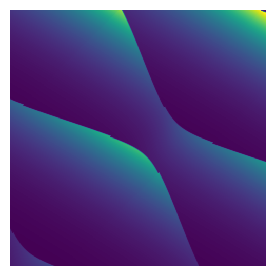

In [5]:
%matplotlib inline
fig, ax = u.plot_CSD(x, y, sensor, poly)  

In [16]:
assert np.all(np.sum([np.gradient(sensor, axis=i) for i in [0,1]], axis=0) == np.gradient(sensor,axis=0) + np.gradient(sensor,axis=1))
np.sum([np.gradient(sensor, axis=i) for i in [0,1]], axis=0)
np.gradient(sensor,axis=0)+np.gradient(sensor,axis=1)

In [9]:
np.gradient(sensor,axis=0) + np.gradient(sensor,axis=1)

array([[ 5.84090507e-11,  5.90509209e-11,  5.99564505e-11, ...,
         2.90185009e-11,  2.92440421e-11,  2.94287139e-11],
       [ 5.87542219e-11,  5.94001001e-11,  6.03195644e-11, ...,
         2.92772206e-11,  2.95047797e-11,  2.96908973e-11],
       [ 5.90442579e-11,  5.96875102e-11,  6.06147984e-11, ...,
         2.96573116e-11,  2.98877459e-11,  3.00762033e-11],
       ...,
       [ 1.13254153e-10,  1.13956580e-10,  1.14826334e-10, ...,
        -1.60966781e-09, -6.44562931e-10, -2.53214718e-10],
       [ 1.14680717e-10,  1.15391685e-10,  1.16272205e-10, ...,
        -1.10751994e-10, -1.71157103e-11,  1.90032877e-11],
       [ 1.15675124e-10,  1.16391497e-10,  1.17279571e-10, ...,
         2.17170798e-11,  3.62374580e-11,  4.20272737e-11]])

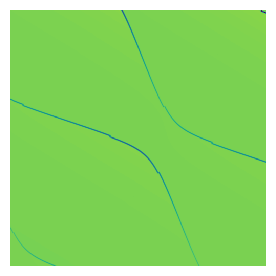

In [7]:
%matplotlib inline
plt.figure(figsize=(c.RESOLUTION/c.DPI, c.RESOLUTION/c.DPI), dpi=c.DPI)
plt.pcolormesh(np.gradient(sensor,axis=0) + np.gradient(sensor,axis=1)  )
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [ ]:
u.get_mask(device, (3,2,1))

### Device

In [ ]:
# device = np.array([[0,1, 0,1,0],[1,0,1,0,1],[0,1,0,1,0]])
# device = np.ones((2,2))
# device = np.ones((1,3))
device = np.array([[1,1,0,0,1]])


# r0 = [c.d_DD*np.sqrt(0.5**2+3**2)]
# t0 = [np.arctan(3/0.5)]
r0 = [6*c.d_DD]
t0 = [0]
S=len(t0)
c.set_global_K(len(u.get_dots_indices(device))+S)

sensors = u.set_sensors_positions(S, device, list_r0=r0, list_theta0=t0)
# sensors = u.set_sensors_positions(S, device)

print(device, sensors)

In [ ]:
# Example usage:
%matplotlib inline
fig, ax = u.plot_device_lattice(device, sensors)
plt.show()

In [ ]:
dist_matrix = u.get_device_distance_matrix(device, sensors)
dist_matrix

In [34]:
C_DD, C_DG = u.exp_decay_model(dist_matrix, model=1)

In [ ]:
C_DG

In [ ]:
x= np.ones((c.K,c.K))


In [ ]:
C_DD

In [ ]:
(np.sum(C_DD, axis=1)-np.diag(C_DD))*np.eye(c.K) 


In [ ]:
C_DD + np.sum(C_DG, axis=1).T*np.eye(c.K) + (np.sum(C_DD, axis=1)-np.diag(C_DD))*np.eye(c.K) 

In [ ]:
c.set_global_NOISE(True)
u.generate_capacitance_matrices(device)